# Data Mining and Exploration [INFR11007]

# Lab 2: Principal component analysis (PCA)

[Principal component analysis (PCA)](https://en.wikipedia.org/wiki/Principal_component_analysis) is one of the most used techniques for exploratory data analysis and preprocessing.

We start this lab off by introducing some fundamental concepts regarding covariance matrices. We then look at several methods for identifying the principal component (PC) directions and scores for an artificial dataset. 

Let's start by importing the packages we will need throughout the lab.

In [1]:
from __future__ import print_function, division
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

## Covariance matrices
Covariance matrices are by definition [symmetric positive semi-definite](https://en.wikipedia.org/wiki/Positive-definite_matrix#Positive-semidefinite). One property of positive semi-definite matrices is that their eigenvalues are all non-negative. You are provided with the function  `generate_spsd_matrix()` which generates a random symmetric positive semi-definite matrix. The `random_seed` parameter can be used to set the numpy random seed in order to ensure reproducible results.

In [2]:
def generate_spsd_matrix(d, random_seed=None):
    """Reproducible random generation of symmetric 
    positive semi-definite matrices. 
    
    Parameters
    ----------
    d : integer
        Number of dimensions.
    
    random_seed : integer
        Random seed number.
        
    Returns 
    ----------
    A : ndarray, shape (n,n)
        Symmetric positive definite matrix.
    
    """
    
    if random_seed is not None:
        np.random.seed(random_seed)
    A = np.random.randn(d,d)
    return np.dot(A.T, A)

### ========== Question 1 ==========

Write a function which checks if a matrix is positive semi-definite. 

Generate a random 10 x 10 matrix by using the `generate_spd_matrix()` function and double-check that it is positive semi-definite by using the function you just wrote.

*Hint: you might find the [`numpy.linalg.eigh()`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.eigh.html) function useful.*

In [7]:
Mat=generate_spsd_matrix(10)
np.min(np.linalg.eigh(Mat)[0]>0)
# first element is smalles eigen value
np.linalg.eigh(Mat)[0][0]>0

True

## Sampling data with a given covariance matrix
### Covariance matrix eigendecomposition

Suppose that you want to sample (i.e. generate) some data points from a multivariate normal distribution with known mean vector and covariance matrix. We will assume that we have access to the tool required to sample from a standard univariate normal distribution, that is, one with zero mean and unit variance (all you need for that is just the cumulative function of the normal distribution). 

We know that if a univariate gaussian random variable $x$ has zero mean and unit variance, then $y = \sigma x + \mu$ has mean $\mu$ and variance $\sigma^2$ . Therefore, we can use this property to sample from an arbitrary univariate normal distribution with mean $\mu$ and variance $\sigma^2$.

By repeating the process described above $d$ times, we can sample from a $d$-dimensional normal distribution with an arbitrary mean vector and diagonal covariance matrix. But, how can we sample from a multivariate normal distribution with given covariance matrix $\mathbf{C}$? The answer is through decomposing the covariance matrix. One such method is the [eigen (or spectral) decomposition](https://en.wikipedia.org/wiki/Eigendecomposition_of_a_matrix) which, for a real symmetric matrix (such as covariance matrices), takes the following form:
$$\mathbf{C} = \mathbf{U} \mathbf{\Lambda} \mathbf{U}^T$$
where $\mathbf{U}$ is an orthogonal matrix containing the (right) eigenvectors of $\mathbf{C}$ and $\mathbf{\Lambda}$ is a diagonal matrix whose entries are the eigenvalues of $\mathbf{C}$. Now, you might wonder how this decomposition can help us sample from a multivariate distribution.

Assume $\mathbf{x}$ is sampled from a standard multivariate normal distribution (i.e. zero mean vector, identity covariance matrix). We can now create a new random variable $\mathbf{y}$ by transforming $\mathbf{x}$ as follows:
$$\mathbf{y} =  \mathbf{U} \mathbf{\Lambda}^{1/2} \mathbf{x} + \mathbf{\mu}$$.

### ========== Question 2 ==========

Assume that $\mathbf{x}$ is a multivariate random variable with zero mean and unit covariance matrix, and $\mathbf{C} = \mathbf{U} \mathbf{\Lambda} \mathbf{U}^T$ is the eigendecomposition of $\mathbf{C}$.

If $\mathbf{y} =  \mathbf{U} \mathbf{\Lambda}^{1/2} \mathbf{x} + \mathbf{\mu}$, show that  $\mathbf{y}$ has mean $\mathbf{\mu}$ and covariance $\mathbf{C} $.

e(Y) = E(U*LAMBDA*x) +mu => U*LAMBDA*E(x) +mu => mu 


cov(y)= cov(U*LAMBDA*x) => (U*Lambda)*cov(x)*(U*Lambda)' => (U*Lambda)*I*(Lambda)*U' => UΛU = C

Please note that the above holds without any assumptions on the probability distribution of $\mathbf{x}$. As a special case, we focus on the multivariate normal distribution. 

The procedure of sampling one data point from a multivariate normal distribution with mean $\mathbf{\mu}$ and covariance matrix $\mathbf{C}$ is as follows:

1. Decompose the covariance matrix by using its eigendecompostion, i.e. $\mathbf{C} = \mathbf{U} \mathbf{\Lambda} \mathbf{U}^T$
2. Sample a data point $\mathbf{x} \in \mathbb{R}^d$ from a standard normal distribution (i.e. zero mean, identity covariance matrix).
3. Transform $\mathbf{x}$ by using $\mathbf{y} =  \mathbf{U} \mathbf{\Lambda}^{1/2} \mathbf{x} + \mathbf{\mu}$.

### ========== Question 3 ==========

Write a function that generates random samples from a multivariate normal distribution with given mean vector and  covariance matrix. You should make use of the [`numpy.random.randn()`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.randn.html) function that generates samples from a standard multivariate gaussian distribution and the eigendecomposition of the covariance matrix. For computing the eigendecomposition of a symmetric matrix you should use the [`numpy.linalg.eigh()`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.eigh.html) function.

**Important:**

Most scientific computing packages like `scikit-learn` follow the $n \times d$ convention for a data matrix, where $n$ is the number of samples and $d$ the dimensionality, that is, $\mathbf{X} \in \mathbb{R} ^ {n \times d}$. Please note that many textbooks and the lecture notes for this course follow reverse notation (i.e. $d \times n$). Here, you should follow the $n \times d$ convention. If the standard normal data are stored in a matrix $\mathbf{X}$, then you should compute $\mathbf{Y}$ by $$\mathbf{Y} = \mathbf{X} \mathbf{\Lambda}^{\frac{1}{2}} \mathbf{U}^T $$

Finally, generate a 3 x 3 random covariance matrix `C` by using the `generate_positive_semi_definite()` function.  Use the function you just wrote to generate 1 million random samples with zero mean and covariance matrix `C`. Compute the empirical covariance matrix of the data (you can use [`numpy.cov()`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.cov.html) by setting `rowvar=False`) and double-check that it is a good estimate of the true covariance matrix `C`.

*Tip: don't get stuck on this, move on after 10 mins or so (it's not critical)*

In [58]:
# Your code goes here
def normalGen(n,d,cov,mu):
    I=np.random.randn(n,d) 
    mat= np.dot(I,np.linalg.cholesky(cov)) +mu
    temp=np.linalg.eigh(cov)
    lambdaa=np.diag(temp[0])**(0.5)
    U=temp[1]
    mat=np.dot(I,np.dot(lambdaa,U.T)) +mu
    
    return mat

Mat=generate_spsd_matrix(3,3)
print(Mat)

np.cov(normalGen(1000,3,Mat,0),rowvar=False)

[[6.67864302 1.3495438  0.83731447]
 [1.3495438  0.66061491 0.16800207]
 [0.83731447 0.16800207 0.13708573]]


array([[6.48886299, 1.2857095 , 0.79075157],
       [1.2857095 , 0.64803181, 0.15652754],
       [0.79075157, 0.15652754, 0.12779801]])

### Note: numpy built-in function
Numpy implements the [`numpy.random.multivariate_normal()`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.multivariate_normal.html) function that can be used to generate samples from a multivariate normal distribution with given mean vector and covariance matrix. You are encouraged to use such built-in functions whenever available, as they will most likely be highly optimised, and bug-free. Nevertheless, it is some times very useful to know what these functions do under the hood.

## Covariance matrix structure

You are provided with the following function `generate_gaussian_data()` that can be used to generate a multivariate gaussian dataset from a given mean and covariance. When the mean and covariance are not defined, they are generated at random. The `random_seed` parameter can be used to ensure reproducible results. The function returns a tuple containing three items; the dataset, the true mean, and the true covariance matrix of the probability distribution the data were sampled from. Execute the cell below to load this function.

In [59]:
def generate_gaussian_data(n_samples, n_features=None, mu=None, cov=None, random_seed=None):
    """Generates a multivariate gaussian dataset.
    
    Parameters
    ----------
    
    n_samples : integer
        Number of samples.
        
    n_features : integer
        Number of dimensions (features).
        
    mu : array, optional (default random), shape (n_features,)
        Mean vector of normal distribution.
        
    cov : array, optional (default random), shape (n_features,n_features)
        Covariance matrix of normal distribution.
    
    random_seed : integer
        Random seed.
        
    Returns
    -------
    
    x : array, shape (n_samples, n_features)
        Data matrix arranged in rows (i.e. 
        columns correspond to features and 
        rows to observations).
    
    mu : array, shape (n_features,)
        Mean vector of normal distribution.
        
    cov : array, shape (n_features,n_features)
        Covariance matrix of normal distribution.
        
    Raises
    ------
    
    ValueError when the shapes of mu and C are not compatible
    with n_features.
    
    """
    
    if random_seed is not None:
        np.random.seed(random_seed)
        
    if mu is None:
        mu = np.random.randn(n_features,)
    else:
        if n_features is None:
            n_features = mu.shape[0]
        else:
            if mu.shape[0] != n_features:
                raise ValueError("Shape mismatch between mean and number of features.")
                
    if cov is None:
        cov = generate_spsd_matrix(n_features, random_seed=random_seed)
    else:
        if (cov.shape[0] != n_features) or (cov.shape[1] != n_features):
            raise ValueError("Shape mismatch between covariance and number of features.")
            
    x = np.random.multivariate_normal(mu, cov, n_samples)
    return (x, mu, cov)

### ========== Question 4 ==========

By using the function provided above, generate a 2-dimensional gaussian dataset consisting of 1000 samples. Use a zero mean and the following covariance matrix:

$$ \mathbf{C} = \left( \begin{array}{ccc} 
1 & 0.3 \\
0.3 & 2 \\ \end{array} \right) $$

Print the empirical mean, covariance and correlation matrices. You should use numpy built-in functions for this purpose, but you are also free to implement your own functions if you are keen. 
Finally, use the seaborn [`jointplot()`](http://seaborn.pydata.org/generated/seaborn.jointplot.html) function to produce a joint scatter plot of the two variables. This function also shows the marginal histograms on the top and right hand sides of the plot. Label axes appropriately. 

In [69]:
# Your code goes here
generate_gaussian_data(100, 2, np.zeros((2,)), np.array([[1,0.3],[0.3,2]]))

(array([[ 1.04668937e+00, -2.25444618e-01],
        [-2.81467945e-01, -8.02453892e-01],
        [ 6.21819206e-01,  1.18542711e+00],
        [-8.73870140e-01,  4.36424833e-01],
        [ 1.92180155e-01, -1.52428332e+00],
        [ 6.15120891e-01, -6.34141610e-01],
        [ 5.57439377e-01,  7.88990001e-01],
        [ 3.79309960e-01,  7.96502312e-01],
        [-1.50665503e+00,  2.05973979e+00],
        [-4.79023576e-02, -1.12411138e+00],
        [-9.33225654e-01,  2.59841332e+00],
        [ 1.28164571e-01, -8.76723460e-01],
        [ 1.59624290e-02,  1.79897489e+00],
        [-5.06263576e-01, -2.88604425e+00],
        [ 6.57393715e-01,  8.94023138e-01],
        [ 6.57490023e-01,  3.97352648e-01],
        [ 1.91921801e-01, -1.18853647e+00],
        [ 2.76366585e-01,  1.09615943e+00],
        [-9.06014208e-01, -1.03838114e+00],
        [-3.70487374e-01,  1.05529016e+00],
        [ 6.23759667e-01,  1.61943398e+00],
        [ 6.13382341e-01, -5.80754067e-01],
        [ 1.86169298e+00, -6.038

### ========== Question 5 ==========

Repeat the same procedure as above, but now modify the covariance matrix such that the **true correlation ceofficient** between the two variables is 0.6 while the variances stay unchanged. 

Visualise the `jointplot()` of the new dataset and compare to the one from the previous question. Do your observations agree with the modification you just applied to the covariance matrix?

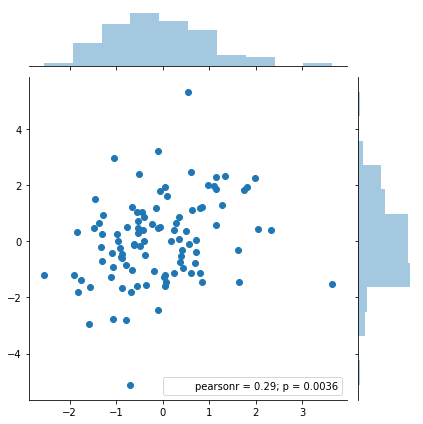

In [75]:
# Your code goes here
set2=generate_gaussian_data(100, 2, np.zeros((2,)), np.array([[1,0.3],[0.3,2]]))
sns.jointplot(x=set2[0][:,0],y=set2[0][:,1])

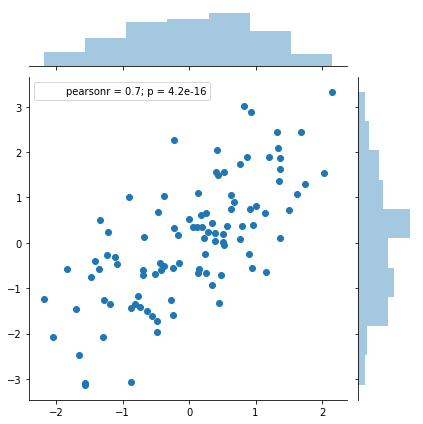

In [78]:
# Your code goes here
set2=generate_gaussian_data(100, 2, np.zeros((2,)), np.array([[1,1],[1,2]]))
sns.jointplot(x=set2[0][:,0],y=set2[0][:,1])

## Principal component analysis (PCA)

Let us now dive into PCA. 

For this section, we will use a 3-dimensional Gaussian dataset. Execute the cell below to generate the dataset and print the true mean and covariance matrix of the distribution the data was sampled from.

In [79]:
# Generates a 3D dataset and prints true mean and covariance
x_3d, mu_true, C_true = generate_gaussian_data(n_samples=1000, n_features=3, random_seed=10)
print("Dataset consists of {} samples and {} features.".format(x_3d.shape[0], x_3d.shape[1]))
print("True mean:\n{}".format(mu_true))
print("True covariance matrix:\n{}".format(C_true))

Dataset consists of 1000 samples and 3 features.
True mean:
[ 1.3315865   0.71527897 -1.54540029]
True covariance matrix:
[[ 1.84368931  0.97606753 -2.05065766]
 [ 0.97606753  0.90946519 -1.55234157]
 [-2.05065766 -1.55234157  2.90680369]]


### ========== Question 6 ==========

Estimate the empirical mean and covariance matrix from this dataset and save them in variables `mu_est` and `C_est` respectively. 

In [86]:
mu_est=np.mean(x_3d,0);print(mu_est)
mu_cov=np.cov(x_3d.T);print(mu_cov)

[ 1.363671    0.73019504 -1.58756481]
[[ 1.7849728   0.90843537 -1.93779655]
 [ 0.90843537  0.85144439 -1.44450311]
 [-1.93779655 -1.44450311  2.70942614]]


### PCA sklearn implementation

Sklearn offers a class implementation of `pca`. Please spend a minute to read the [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) of this class. The principal component (PC) directions of a dataset are computed by using the [`fit()`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA.fit) method and stored into the `components_` attribute. The PC scores can be computed by using the [`transform()`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA.transform) method. The amount of variance explained by each of the selected components is stored into the `explained_variance_` attribute. 

Please note, this method centers the input data (i.e. removes the mean) before computing the PC directions.


### ========== Question 7 ==========

Initialise a `pca` object and "fit" it using the dataset `x_3d`. Print the three PC directions. Store the PC scores for `x_3d` in an array called `pc_scores`.

*Hint: according to the documentation the components are stored row-wise, i.e. the `components_ array` has shape `[n_components, n_features]`. You should print the PC directions column-wise, i.e. take the transpose of the `components_` array.*

In [124]:
import sklearn as skn
from sklearn.decomposition import PCA
pca= PCA(n_components=3)
pca.fit(x_3d)
print("directions in the 3D dimensions of the 2 components:\n", pca.components_.T)
pc_scores=pca.transform(x_3d)
print("scores: \n",pc_scores)
pc_scores.shape

directions in the 3D dimensions of the 2 components:
 [[-0.56052625 -0.78030784  0.27736257]
 [-0.38349242  0.54142509  0.74819278]
 [ 0.73399174 -0.31301525  0.60272512]]
scores: 
 [[-0.34835537 -0.25572171  0.20202817]
 [-2.1642542  -0.60471779  0.04453689]
 [ 1.08163972  0.68938103  0.0230694 ]
 ...
 [ 0.61803508  1.06416972  0.05518647]
 [ 1.75112399  0.29607637 -0.43441915]
 [ 0.92571975 -0.28384395  0.09541068]]


(1000, 3)

Most often, we do not want to compute all PC directions, but only a few (i.e. dimensionality reduction). We can define the desired number of PCs by setting the [`n_components`]() parameter appropriately when we initialise the `pca` object. 

### ========== Question 8 ==========

Initialise a `pca_new` object with 2 PCs and "fit" it using the dataset `x_3d`. Print the two PC directions. 

*Hint: the 2 PC directions should be the same as the first 2 directions you computed in the previous question. The reason for this is ultimately that PCA by sequential and simultaneous variance maximisation give the same result.*

In [224]:
import sklearn as skn
from sklearn.decomposition import PCA
pca= PCA(n_components=2)
pca.fit(x_3d)
print("directions in the 3D dimensions of the 2 components:\n", pca.components_.T)
pc_scores2=pca.transform(x_3d)
print("scores: \n",pc_scores2)


directions in the 3D dimensions of the 2 components:
 [[-0.56052625 -0.78030784]
 [-0.38349242  0.54142509]
 [ 0.73399174 -0.31301525]]
scores: 
 [[-0.34835537 -0.25572171]
 [-2.1642542  -0.60471779]
 [ 1.08163972  0.68938103]
 ...
 [ 0.61803508  1.06416972]
 [ 1.75112399  0.29607637]
 [ 0.92571975 -0.28384395]]


### PCA implementation #1: covariance matrix eigendecomposition

Now we want to implement PCA from scratch. The procedure can be summarised as follows:

1. Center the data (i.e. remove the mean).
2. Compute the empirical covariance matrix.
3. Perform the eigendecomposition of the estimated covariance matrix.
4. Sort eigenvalues and associated eigenvectors, in eigenvalue descending order. The sorted eigenvectors correspond to the PC directions. If we want to reduce the dimensionality, we select the first `k` eigenvectors corresponding to the `k` largest eigenvalues (`k` < `d`).
5. To compute PC scores we project the centered data matrix (i.e. matrix product) onto the PC directions.

(Regarding 3 and 4: some algorithms for eigendecompositions allow you to specify the number of eigenvectors and eigenvalues that should be computed. You then do not have to compute the complete eigendecomposition, which is wasteful if you are only interested in a few principle components.)

### ========== Question 9 ==========

Compute and print all three PC directions in the dataset `x_3d` by using the procedure described above. Hopefully, you will have already performed the first two steps in question 6. Then compute the PC scores for the centered data matrix.

As happens very often when writing code, it is likely that there will be a few bugs in your implementation. To double-check that your code is correct, compare the computed PC directions and scores to the ones achieved in question 7 with scikit-learn.

*Hint: you might (or might not) find that some of the PC directions/scores you have computed have opposite signs to the ones returned by the sklearn implementation. Do not worry about this, the two solutions are equivalent (why?). To make debugging easier, you are provided with the following function, `solutions_equivalent()` which tests wether two solutions are equivalent, regardless of their signs. Execute the following cell to load this function.*

In [129]:
def solutions_equivalent(b1, b2):
    """Checks whether two PC directions/scores
    solutions are equivalent regardless of their .
    respective signs.
    
    Parameters
    ----------
    
    s1 : array, shape(n_axes,)
        First solution.
        
    s2 : array, shape(n_axes,)
        Second solution.
        
    Returns
    -------
    
    True if solutions are equivalent.
    
    Raises
    ------
    
    ValueError if the two bases do not have
    the same dimensionality.
    
    """
    
    s1 = np.asarray(b1)
    s2 = np.asarray(b2)
    
    if s1.shape != s2.shape:
        raise ValueError("Solutions must have the same dimensionality.")
    
    dims_equal = []
    for dim in range(s1.shape[1]):
        if (np.allclose(s1[:,dim],s2[:,dim]) or np.allclose(s1[:,dim],-s2[:,dim])):
            dims_equal.append(True)
        else:
            dims_equal.append(False)
    return all(element for element in dims_equal)

In [139]:
def pcaManual(x):
    
    x=x-np.mean(x,0)
    cov=np.cov(x,rowvar=False)

    eigenValues, eigenVectors = np.linalg.eigh(cov)

    idx = eigenValues.argsort()[::-1]   
    eigenValues = eigenValues[idx]
    eigenVectors = eigenVectors[:,idx]
    pcaScore=np.dot(x,eigenVectors)
    return pcaScore

solutions_equivalent(pc_scores,pcaManual(x_3d))    

True

### PCA implementation #2: data matrix singular value decomposition (SVD)

### ========== Question 10 ==========

The SVD decomposition of the centered data matrix is: $$\mathbf{X} =  \mathbf{V} \mathbf{S} \mathbf{U}^T  $$ where the columns $\mathbf{V} \in \mathbb{R}^{n\times n}$ and $\mathbf{U} \in \mathbb{R}^{d\times d}$ contain the left- and right-singular vectors of $\mathbf{X}$, and $\mathbf{S} \in \mathbb{R}^{n\times d}$ is a diagonal matrix containing its singular values.

Compute the PC directions and scores in the dataset `x_3d` by using the [SVD](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.svd.html) decomposition of the centered data matrix (cf. lecture notes). Double-check that these are correct by using the `solutions_equivalent()` function.

*Hint 1: make sure you center the data before computing the SVD of `x_3d`.*

*Hint 2: Remember, we are dealing with `n` x `d` data matrices here, as opposed to `d` x `n` matrices in the lecture notes (that is why we have written $\mathbf{X} =  \mathbf{V} \mathbf{S} \mathbf{U}^T$ as opposed to $\mathbf{X} =  \mathbf{U} \mathbf{S} \mathbf{V}^T$ in the lecture notes). Which singular vectors of the centered data matrix correspond to the PC directions/scores in this case?*

In [293]:
v, s, ut = np.linalg.svd(x,full_matrices=True)

In [301]:
ut

array([[-0.56052625, -0.38349242,  0.73399174],
       [ 0.78030784, -0.54142509,  0.31301525],
       [-0.27736257, -0.74819278, -0.60272512]])

In [286]:
e, e2 = np.linalg.eigh(x.T.dot(x))
e3, e4 = np.linalg.eigh(x.dot(x.T))

In [300]:
e4

array([[ 8.60804154e-03, -6.28207396e-01, -6.89292721e-03, ...,
        -3.50490540e-03, -1.63739453e-02,  1.00276508e-02],
       [ 4.33789439e-04,  1.69798274e-01,  3.35435566e-01, ...,
        -1.52012977e-03, -1.27843546e-02, -8.02344337e-03],
       [-1.19386612e-02,  1.95880343e-01, -1.27086051e-01, ...,
         4.31920414e-03, -1.17747046e-03,  2.05994341e-03],
       ...,
       [ 4.07901541e-02,  8.99214472e-03,  4.65778834e-03, ...,
         1.11423300e-02, -8.77106609e-02,  1.92637315e-02],
       [ 1.31714974e-02,  3.11472920e-02, -3.55080546e-02, ...,
        -5.48123531e-02, -1.52500512e-02,  1.46199942e-02],
       [-4.95680172e-03, -3.07955033e-02,  1.53908167e-02, ...,
         8.79411542e-03,  2.49170105e-02,  1.31722076e-02]])

In [426]:
def SVD(x,k):
    # u are the directions 
    # mhat is low dimensional representation of X
    x=x-np.mean(x,0)
    v, s, ut = np.linalg.svd(x,full_matrices=False)
    u=ut.T
    
    idx = s.argsort()[::-1] 
    s= s[idx]; v = v[:,idx]; u = u[:,idx]
    s=s[:k];    v=v[:,:k];    u=u[:,:k];
    
    s=np.diag(s)
    scores=np.dot(s, v.T)
    Mhat = np.dot(u, scores)
    
    return Mhat,scores,u
est, SVDscores,u=SVD(x_3d,3)
solutions_equivalent(pc_scores,SVDscores.T)    

True

Assume now that you want to do dimensionality reduction by using `k` PCs only. One option would be to follow the same procedure as above and discard the last `d-k` PC directions. This, however, can be rather wasteful. There exist [SVD variations](https://en.wikipedia.org/wiki/Low-rank_approximation) that approximate the matrix $\mathbf{X}$ with a low-rank matrix. 

Scipy implements the function [`svds`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.svds.html) that computes only the `k` largest singular values/vectors of a given matrix. 

### ========== Question 11 ==========

Compute and print the first 2 PC directions by using the [`svds`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.svds.html) decomposition of the centered data matrix.

*Hint: as opposed to the numpy function `numpy.linalg.svd`, `svds` does not automatically sort the singular values/vectors in singular value descending order. You should do this operation manually.*

In [227]:
from scipy.sparse.linalg import svds

def SVD2(x,k):
    
    x=x-np.mean(x,0)
    v, s, ut = svds(x,k)
    u=ut.T
    
    idx = s.argsort()[::-1] 
    s= s[idx]; v = v[:,idx]; u = u[:,idx]
    
    s=np.diag(s)
    scores=np.dot(s, v.T)
    Mhat = np.dot(u, scores)
    
    return Mhat,scores
est, SVDscores=SVD2(x_3d,2)
solutions_equivalent(pc_scores2,SVDscores.T)    


True

### PCA implementation #3: Gram matrix eigendecomposition

We have seen in the lectures that we can compute the PC directions and scores by performing the eigendecomposition of the [Gram matrix](https://en.wikipedia.org/wiki/Gramian_matrix) $\mathbf{G}$.

The procedure of computing the PC directions and scores based on the eigendecomposition of the Gram matrix is as follows:
1. Center data.
2. Compute Gram matrix.
3. Perform the eigendecomposition of the Gram matrix.
4. Sort eigenvalues and eigenvectors in decreasing eigenvalue order.
5. Pick the first `k` eigenvectors. This is required even if we do not to perform dimensionality reduction, since the eigendecomposition of the Gram matrix will yield `n` eigenvectors.
6. The PC scores are given by these eigenvectors scaled by $\mathbf{\Sigma} ^ {1/2}$, where $\mathbf{\Sigma}$ is the diagonal matrix containing the eigenvalues of the gram matrix.
7. To get the PC directions, we project the centered data matrix onto the eigenvectors and scale by $\mathbf{\Sigma} ^ {-1/2}$.

### ========== Question 12 ==========

Compute the PC directions and scores in the dataset `x_3d` by using the eigendecomposition of the Gram matrix. Double-check that these are correct by using the `solutions_equivalent()` function.

In [399]:
x=x_3d-np.mean(x_3d,0)
Gram= x.dot(x.T)
k=3
eigenValues, eigenVectors = np.linalg.eigh(Gram)

idx = eigenValues.argsort()[::-1]   
eigenValues = eigenValues[idx]
eigenVectors = eigenVectors[:,idx]

eigenVectors=eigenVectors[:,:k]; sigma =np.diag(eigenValues[:k])

scores=np.dot(eigenVectors,sigma**(0.5))
direc =np.dot( np.dot(x.T, eigenVectors),np.diag(eigenValues[:k]**(-0.5)))


In [402]:
scores.shape

(1000, 3)

In [307]:
def GRAM(x,k):
    
    x=x_3d-np.mean(x_3d,0)
    Gram= x.dot(x.T)

    eigenValues, eigenVectors = np.linalg.eigh(Gram)

    idx = eigenValues.argsort()[::-1]   
    eigenValues = eigenValues[idx]
    eigenVectors = eigenVectors[:,idx]

    eigenVectors=eigenVectors[:,:k]; sigma =np.diag(eigenValues[:k])

    scores=np.dot(eigenVectors,sigma**(0.5))
    direc =np.dot( np.dot(x.T, eigenVectors),np.diag(eigenValues[:k]**(-0.5)))

    return direc,scores
est, SVDscores=GRAM(x_3d,3)
solutions_equivalent(pc_scores,SVDscores)    
#est.T

True

### ========== Question 13 ==========

Can you think of a particular case where it would be beneficial to compute the PC scores by using the eigendecomposition of the Gram matrix, as opposed to SVD decomposition of the data matrix?

Dont need to compute the covariance matrix.


One particular case where we would use the eigendecomposition of the Gram matrix, is when we only have access to that matrix and not the data matrix. In this case, it is still possible to identify the PC scores and hence do dimensionality reduction, as we will see in Lab 3.

In addition, by working directly with the Gram matrix, we can use the kernel trick and identify non-linear manifolds by using almost the same bit of code. This is exactly what [kernel principal component analysis (kPCA)](https://en.wikipedia.org/wiki/Kernel_principal_component_analysis) does, but more on this in the next lab.

## Dimensionality reduction with PCA

PCA can be used to reduce the dimensionality of a data from $d$ to $k$.

### ========== Question 14 ==========

Use any implementation of PCA of your choice to project the dataset `x_3d` onto 1, 2, and 3 dimensions. This projection should just take the form $$\mathbf{X}_{red} = \mathbf{X} \mathbf{W}_{1:k}$$ where $\mathbf{X}$ is the centered data matrix and $\mathbf{W}$ is the matrix containing the PC directions as columns. The approximation of the data by the $k$ principle components is $$\mathbf{X}_{recon} = \mathbf{X}_{red} \mathbf{W}_{1:k} ^ T + \mathbf{\mu}$$.

Plot the mean-squared-error and explained variance of the approximation as a function of the number of components used. Label axes appropriately. You should make use of the sklearn [`mean_squared_error()`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html) and [`explained_variance_score()`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.explained_variance_score.html) metrics. For `explained_variance_score()`, you should set the `multioutput` parameter to `variance_weighted`.

In [401]:
xhat.shape

(1000, 3)

In [414]:
from sklearn.metrics import explained_variance_score,mean_squared_error

exp=np.zeros((3,1))
mse=np.zeros((3,1))
for i in range(3):
    k=i+1
    direc,scores= GRAM(x_3d,k)
    x=x_3d-np.mean(x_3d,0)
    xhat=np.dot(np.dot(x,direc), direc.T)+np.mean(x_3d,0)
    print(i)
    exp[i,0]=explained_variance_score(x_3d, xhat,multioutput='variance_weighted');
    mse[i,0]=  mean_squared_error(x_3d, xhat); 

0
1
2


Text(0.5,1,'MSE per PC')

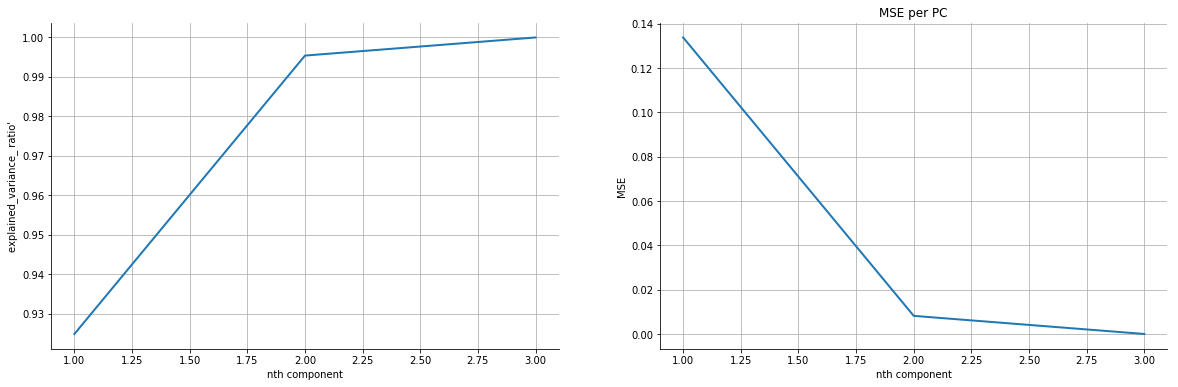

In [416]:
plt.figure(figsize=(20,6))
ax=plt.subplot(1,2,1)
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  
ax.grid('on')
ax.set_ylabel("explained_variance_ ratio'")
ax.set_xlabel("nth component")

xas=np.arange(1,4)
plt.plot(xas,exp,linewidth=2, label="explained var ratio")

ax=plt.subplot(1,2,2)
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  
ax.grid('on')
ax.set_ylabel("MSE")
ax.set_xlabel("nth component")


plt.plot(xas,mse,linewidth=2)
plt.title("MSE per PC")

The black points lie on a line (the 1st PC direction). The red points lie in a 2D plane (spanned by the first two PC directions).

### ========== Question 15 ==========

How can you compute the variance explained by k principal components by only looking at the eigenvalues of the covariance matrix?

*Your answer goes here*


In [ ]:
# Your code goes here


## Low-rank SVD approximation for image compression [optional]

In lecture, we have seen that the SVD allows us to find a low rank approximation of the data matrix. We here exemplify the low rank approximation property of the SVD on a image compression task.

As you might already know, grey-scale images are represented in the digital world as 2D matrices, whose elements correspond to pixel intensities. We here approximate this matrix by a low-rank approximation through the SVD. If there are correlations between the pixels in the image (which happens to be the case for [natural images](http://www.naturalimagestatistics.net/)), then we should be able to achieve a relatively good reconstruction of the image by using only a few components.

Let us first load a sample image from the scipy package:

In [417]:
# Load sample image
from scipy.misc import face
img = face(gray=True)
print("Image array dimensionality: {}".format(img.shape))

Image array dimensionality: (768, 1024)


We can visualise the image by using the matplotlib imshow function:

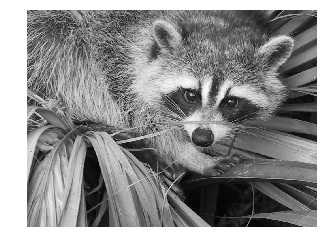

In [418]:
# Show image 
sns.set_style("white")
plt.figure()
plt.imshow(img, cmap=plt.cm.gray)
plt.axis("off")
plt.show()

### ========== Question 16 [optional] ==========

Write a function image_low_rank_approx() that takes as input an image (i.e. 2-dimensional array) and an integer k and reconstructs the image by using a k-rank SVD approximation.

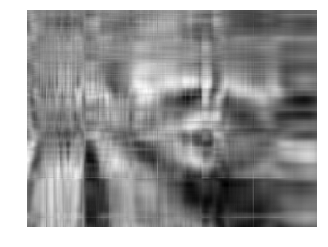

In [450]:
def image_low_rank_approx(pic,k):
    pic=img
    Mhat,scores,direc=SVD(pic,k)
    x=pic-np.mean(pic,0)
    xhat=np.dot(np.dot(x,direc), direc.T)+np.mean(pic,0)
    return xhat

img2=image_low_rank_approx(img,5)
# Show image 
sns.set_style("white")
plt.figure()
plt.imshow(img2, cmap=plt.cm.gray)
plt.axis("off")
plt.show()

### ========== Question 17 [optional] ==========
Perform a low-rank approximation of the image stored in img by using a varying number of ranks (i.e. from 1 to 500) and visualise the approximation. What do you observe?

In [ ]:
# Your code goes here


*Your answer goes here.*

